## Importing the Necessary Libraries

In [106]:
import numpy as np
import pandas as pd
import logging
import os
import subprocess
import yaml
import datetime 
import gc
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

## File Ingestion and Schema Validation

### Writing the Testutility Module with the Necessary Functions

In [2]:
# Read the YAML file carrying the information about the dataset
def read_yaml_file(file_path):
    with open(file_path, 'r') as stream:
        try:
            return yaml.load(stream)
        except yaml.YAMLError as exc:
            logging.error(exc)

# We will use this function to replace multiple space characters with one space character
def replacer(string, char):
    pattern = char + '{2,}'
    string = re.sub(pattern, char, string)
    return string

# This function is used to validate the cloumns of the dataset by comparing them to the set of expected columns in the YAML file
def col_validate(df, col_config):
    cols = df.columns
    cols = cols.str.strip()
    cols.str.replace("_", "")
    cols = list(map(lambda x: replacer(x, ' '), list(cols)))
    expected_col = list(map(lambda x: x.lower(),  col_config['columns']))
    cols.sort()
    expected_col.sort()
    if len(cols) == len(expected_col) and cols == expected_col:
        return 1
    else:
        print("Column name and Column Length Validation Failed..")
        mismatched_columns_file = list(set(cols).difference(expected_col))
        print("Following File Columns are not in the YAML file", mismatched_columns_file)
        missing_YAML_file = list(set(expected_col).difference(cols))
        print("Following YAML Columns are not in the File Uploaded", missing_YAML_file)
        logging.info(f'Columns Read: {cols}')
        logging.info(f'Expected Columns: {expected_col}')
        return 0

### Creating and Writing to the YAML File

In [3]:
%%writefile dataset.yaml
columns: 
  - id
  - tweet
  - label
dataset_name: training_news
dtypes: 
    id: int
    tweet: str
    label: str
file_name: "Constraint_English_Train - Sheet1"
file_type: csv
skip_leading_rows: 1
table_name: news

Overwriting dataset.yaml


### Read the Configuration File

In [4]:
# Reading the YAML file and displaying its content
config_file = read_yaml_file("dataset.yaml")

# The content of the file are the properties of the datasets we are trying to validate before importing them 
config_file

C:\Users\MEPI\anaconda3\lib\site-packages\ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys


{'columns': ['id', 'tweet', 'label'],
 'dataset_name': 'training_news',
 'dtypes': {'id': 'int', 'tweet': 'str', 'label': 'str'},
 'file_name': 'Constraint_English_Train - Sheet1',
 'file_type': 'csv',
 'skip_leading_rows': 1,
 'table_name': 'news'}

In [5]:
# Read the name of the file 

file_type = config_file['file_type']
source_file = config_file['file_name']+f'.{file_type}'

print("The name of the source file is:", source_file)

The name of the source file is: Constraint_English_Train - Sheet1.csv


In [6]:
# Importing the training dataset using pandas

training_df = pd.read_csv(source_file)
training_df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [7]:
# We change the name of the file we want to import in the YAML file to import the testing dataset

with open("dataset.yaml") as f:
    config_file = yaml.safe_load(f)
    
config_file["name"] = "english_test_with_labels - Sheet1"

with open("dataset.yaml", "w") as f:
    yaml.dump(config_file, f)

In [8]:
# Importing the testing dataset using pandas

testing_df = pd.read_csv(config_file["name"]+f'.{file_type}')
testing_df.head()

,id,tweet,label
0,1,Our daily update is published. States reported...,real
1,2,Alfalfa is the only cure for COVID-19.,fake
2,3,President Trump Asked What He Would Do If He W...,fake
3,4,States reported 630 deaths. We are still seein...,real
4,5,This is the sixth time a global health emergen...,real


In [9]:
# We change the name of the file we want to import in the YAML file to import the validation dataset

with open("dataset.yaml") as f:
    config_file = yaml.safe_load(f)
    
config_file["name"] = "Constraint_English_Val - Sheet1"

with open("dataset.yaml", "w") as f:
    yaml.dump(config_file, f)
    
config_file

{'columns': ['id', 'tweet', 'label'],
 'dataset_name': 'training_news',
 'dtypes': {'id': 'int', 'label': 'str', 'tweet': 'str'},
 'file_name': 'Constraint_English_Train - Sheet1',
 'file_type': 'csv',
 'name': 'Constraint_English_Val - Sheet1',
 'skip_leading_rows': 1,
 'table_name': 'news'}

In [10]:
# Importing the validation dataset using pandas

validation_df = pd.read_csv(config_file["name"]+f'.{file_type}')
validation_df.head()

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real


## Cleaning the Data 

In [ ]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

In [12]:
# Function for expanding contractions
def expand_contractions(text, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return re.compile('(%s)' % '|'.join(contractions_dict.keys())).sub(replace, text)


# The function for checking if the string (hashtag, in our case) consists of only lower case letters
def isAlllower(sentence):
    flag = True
    
    for char in sentence:
        if(char.isupper()):
            flag = False
            
    return flag


# The function for checking if the string (hashtag, in our case) consists of only upper case letters
def isAllupper(sentence):
    flag = True
    
    for char in sentence:
        if(char.islower()):
            flag = False
            
    return flag


# The function for cleaning hashtags and extracting words from them, if possible.
def clean_hashtag(hashtag):
    
    hashtag = re.sub(r'#', '', hashtag)
    
    if(isAllupper(hashtag) | isAlllower(hashtag)):
        return hashtag
    else:
        hashtag = re.sub(r'(\w)([A-Z][a-z])', r'\1 \2', hashtag)
    
    return hashtag
    

# The main function for cleaning tweets
def clean_tweet(tweet):
    
    words = tweet.split()    #Tokenizing phrases according to space characters
    
    for word in words:
        if re.search(r'#\w+', word):
            i = words.index(word)
            hashtag = re.search(r'#\w+', word).group()
            cleaned_hashtag = clean_hashtag(hashtag)    #Extracting words from hashtags 
            new_word = re.sub(hashtag, cleaned_hashtag, word)    #Replacing the hashtag by the extracted words
            words[i] = new_word
    
    tweet = ' '.join(words)
    
    tweet = re.sub(r'https?:\/\/.\S+|^RT[\s+]', "", tweet)    #Removing URLs and any twitter special characters
    
    tweet = tweet.lower()    #Lowering the case of all letters
    
    tweet = expand_contractions(tweet)    #Expanding any contracted words
    
    tweet = re.sub(r'[^a-zA-Z0-9]', " ", tweet)    #Removing any non-alphanumeric characters
    tweet = re.sub(r'\s+', " ", tweet)    #Replacing multiple space characters with one space character
    tweet = re.sub(r'^\s', "", tweet)
    
    stop_words = set(stopwords.words('english'))    #Removing stop words
    tokenized_words = word_tokenize(tweet)

    without_stopwords = [w for w in tokenized_words if not w in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in without_stopwords]    #Lemmatizing the rest of the words

    tweet = ' '.join(lemmatized_words)
    
    
    return tweet

In [14]:
# Cleaning the training data
for i in range(len(training_df['tweet'])):
    training_df['tweet'][i] = clean_tweet(training_df['tweet'][i])
    
training_df

C:\Users\MEPI\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,tweet,label
0,1,cdc currently report 99031 death general discr...,real
1,2,state reported 1121 death small rise last tues...,real
2,3,politically correct woman almost us pandemic e...,fake
3,4,india fight corona 1524 covid testing laborato...,real
4,5,populous state generate large case count look ...,real
...,...,...,...
6415,6416,tiger tested positive covid 19 please stay awa...,fake
6416,6417,autopsy prove covid 19 blood clot pneumonia ou...,fake
6417,6418,post claim covid 19 vaccine already developed ...,fake
6418,6419,aamir khan donate 250 cr pm relief care fund,fake


In [15]:
# Cleaning the testing data
for i in range(len(testing_df['tweet'])):
    testing_df['tweet'][i] = clean_tweet(testing_df['tweet'][i])
    
testing_df

C:\Users\MEPI\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,tweet,label
0,1,daily update published state reported 734k tes...,real
1,2,alfalfa cure covid 19,fake
2,3,president trump asked would catch coronavirus ...,fake
3,4,state reported 630 death still seeing solid na...,real
4,5,sixth time global health emergency declared in...,real
...,...,...,...
2135,2136,corona virus update state wise detail total co...,real
2136,2137,tonight 12 midnight onwards disaster managemen...,fake
2137,2138,296 new case covid19 nigeria plateau 85 enugu ...,real
2138,2139,cdcemergency dyk cdcgov one stop shop covid19 ...,real


In [16]:
# Cleaning the validation data
for i in range(len(validation_df['tweet'])):
    validation_df['tweet'][i] = clean_tweet(validation_df['tweet'][i])
    
validation_df

C:\Users\MEPI\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,tweet,label
0,1,chinese converting islam realising muslim affe...,fake
1,2,11 13 people diamond princess cruise ship inti...,fake
2,3,covid 19 caused bacterium virus treated aspirin,fake
3,4,mike penny rnc speech praise donald trump covi...,fake
4,5,6 10 sky edconwaysky explains latest covid19 d...,real
...,...,...,...
2135,2136,donald trump wrongly claimed new zealand big s...,fake
2136,2137,current understanding covid19 spread mostly pe...,real
2137,2138,nothing scream sat around fuck lockdown quite ...,fake
2138,2139,birx say covid 19 outbreak control people move,fake


## Combining the Datasets to Obtain A Comprehensive Dataset 

In [17]:
# Appending datasets to a comprehensive one to perform exploratory data analysis

clean_data = training_df.append(testing_df.append(validation_df, ignore_index = True), ignore_index = True)

clean_data

,id,tweet,label
0,1,cdc currently report 99031 death general discr...,real
1,2,state reported 1121 death small rise last tues...,real
2,3,politically correct woman almost us pandemic e...,fake
3,4,india fight corona 1524 covid testing laborato...,real
4,5,populous state generate large case count look ...,real
...,...,...,...
10695,2136,donald trump wrongly claimed new zealand big s...,fake
10696,2137,current understanding covid19 spread mostly pe...,real
10697,2138,nothing scream sat around fuck lockdown quite ...,fake
10698,2139,birx say covid 19 outbreak control people move,fake


In [18]:
clean_data.shape

(10700, 3)

In [19]:
training_df.shape

(6420, 3)

In [20]:
testing_df.shape

(2140, 3)

In [21]:
validation_df.shape

(2140, 3)

In [22]:
# Checking for any empty rows
clean_data.isnull().sum()

id       0
tweet    0
label    0
dtype: int64

In [23]:
# Deleting the 'id' column to facilitate the use of one index

del clean_data['id']

In [24]:
# Descriptive statistics about the comprehensive dataset
clean_data.describe()

,tweet,label
count,10700,10700
unique,10352,2
top,herd immunity strategy unethical unlikely succ...,real
freq,7,5600


In [25]:
# Seperating all the news into two seperate dataframes according to their classification

fake_news = clean_data[clean_data['label']=='fake']

real_news = clean_data[clean_data['label']=='real']

In [26]:
fake_news

,tweet,label
2,politically correct woman almost us pandemic e...,fake
7,obama call trump coronavirus response chaotic ...,fake
8,clearly obama administration leave kind game p...,fake
9,retraction hydroxychloroquine chloroquine with...,fake
11,nba poised restart month march reported utah j...,fake
...,...,...
10691,novel coronavirus man made,fake
10693,swine flu virus dangerous novel coronavirus,fake
10695,donald trump wrongly claimed new zealand big s...,fake
10697,nothing scream sat around fuck lockdown quite ...,fake


In [27]:
real_news

,tweet,label
0,cdc currently report 99031 death general discr...,real
1,state reported 1121 death small rise last tues...,real
3,india fight corona 1524 covid testing laborato...,real
4,populous state generate large case count look ...,real
5,covid act found average person illinois covid ...,real
...,...,...
10690,nh service could take long 2 year recover effe...,real
10692,yesterday erroneously reported 7 new case jiga...,real
10694,india fight corona increasing number covid19 t...,real
10696,current understanding covid19 spread mostly pe...,real


#### We can see that in our overall dataset we have 52.34% classified as 'real,' while 47.66% classsified as 'fake.'

<function matplotlib.pyplot.show(*args, **kw)>

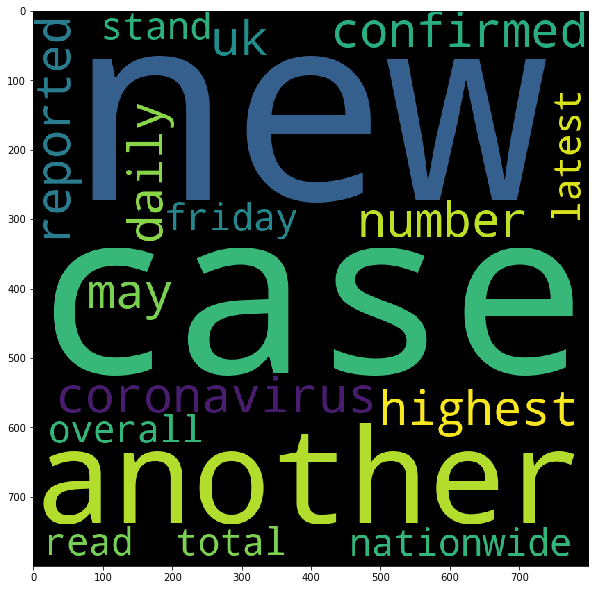

In [28]:
# Wordcloud for most common words in the news categorized as 'real'

content_words = ""

for news in real_news.tweet:
    
    news = str(news)
    
    tokenized_news = news.split()
    
    
for word in tokenized_news:
    content_words = content_words + word + " "
    

wordcloud = WordCloud(width = 800, height = 800, background_color = 'black', min_font_size = 10).generate(content_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.tight_layout(pad = 0)

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

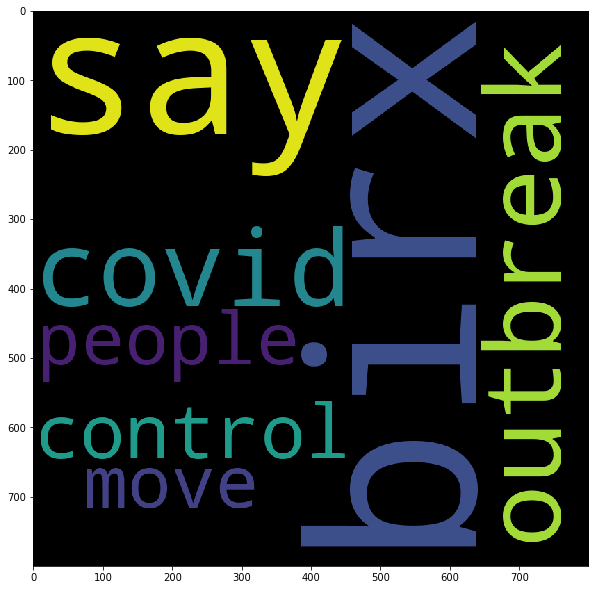

In [29]:
# Wordcloud for most common words in the news categorized as 'fake'

content_words = ""

for news in fake_news.tweet:
    
    news = str(news)
    
    tokenized_news = news.split()
    
    
for word in tokenized_news:
    content_words = content_words + word + " "
    

wordcloud = WordCloud(width = 800, height = 800, background_color = 'black', min_font_size = 10).generate(content_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.tight_layout(pad = 0)

plt.show

## Tf-Idf Vectorization

In [30]:
# Deleting the column 'index' from all of the dataframes

del training_df['id']
del testing_df['id']
del validation_df['id']

In [32]:
# Combining the training and validation sets to form one training set

training_df = training_df.append(validation_df, ignore_index = True)

In [33]:
# Creating the list of features (words)
tfidf_train = TfidfVectorizer()
vectors = tfidf_train.fit_transform(list(training_df['tweet']))

# Printing the vector representation of each tweet in a dataframe 
tweet_vectors = np.array(vectors.todense().tolist())
tweet_vectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
# Transforming the testing set 
vectors = tfidf_train.transform(list(testing_df['tweet']))

test_vectors = np.array(vectors.todense().tolist())
test_vectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Training the Models and Testing the Performance

In [95]:
# Function for outputting different metrics to measure performance

def measure_performance(predicted, expected):
    print("Accuracy: %", round(accuracy_score(expected, predicted)*100, 2))
    print("Precision: %", round(precision_score(expected, predicted, average = 'weighted')*100, 2))
    print("Recall: %", round(recall_score(expected, predicted, average = 'weighted')*100, 2))
    print("F1: %", round(f1_score(expected, predicted, average = 'weighted')*100, 2))

### Setting the Training and Testing Data

In [34]:
tweet_vectors.shape

(8560, 14803)

In [35]:
# Creating the final training dataframe that hosts the vectorized tweets and their labels

training_data = pd.DataFrame()
training_data['tweet_vectors'] = tweet_vectors.tolist()
training_data['label'] = training_df['label']

training_data

,tweet_vectors,label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",real
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",real
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",fake
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",real
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",real
...,...,...
8555,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",fake
8556,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",real
8557,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",fake
8558,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",fake


In [37]:
# Creating the final testing dataframe that contains the vectorized tweets and their labels

testing_data = pd.DataFrame()
testing_data['tweet_vectors'] = test_vectors.tolist()
testing_data['label'] = testing_df['label']

testing_data

,tweet_vectors,label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",real
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",fake
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",fake
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",real
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",real
...,...,...
2135,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",real
2136,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",fake
2137,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",real
2138,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",real


In [51]:
# Seperating the tweets from the labels in both the training and testing sets

training_tweets = training_data['tweet_vectors']
training_labels = training_data['label']

testing_tweets = testing_data['tweet_vectors']
testing_labels = testing_df['label']

#### Gaussian Naive Bayes

Performance Indicators:
Accuracy: % 84.63
Precision: % 85.17
Recall: % 84.63
F1: % 84.51


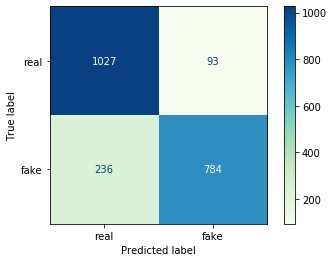

In [99]:
# Fitting and testing the model on the testing data
gnb = GaussianNB()

gnb_model = gnb.fit(list(training_tweets), list(training_labels))
predicted_labels = gnb_model.predict(list(testing_tweets))

# Plot the confusion matrix of the model's predictions
plot_confusion_matrix(gnb_model, list(testing_tweets), list(testing_labels), labels = ['real', 'fake'],
                      cmap = 'GnBu', colorbar = True)

# Printing the performance indicators
print("Performance Indicators:")
measure_performance(list(predicted_labels), list(testing_labels))

#### Logistic Regression

Performance Indicators:
Accuracy: % 92.06
Precision: % 92.1
Recall: % 92.06
F1: % 92.06


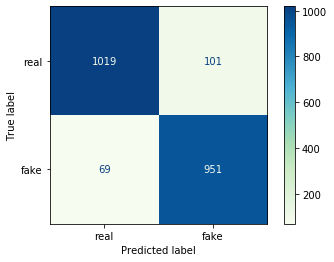

In [101]:
# Fitting and testing the model on the testing data
LR = LogisticRegression()

LR_model = LR.fit(list(training_tweets), list(training_labels))
predicted_labels = LR_model.predict(list(testing_tweets))

# Plot the confusion matrix of the model's predictions
plot_confusion_matrix(LR_model, list(testing_tweets), list(testing_labels), labels = ['real', 'fake'],
                      cmap = 'GnBu', colorbar = True)

# Printing the performance indicators
print("Performance Indicators:")
measure_performance(list(predicted_labels), list(testing_labels))

#### Support Vector Machine (SVM)

- ##### Support Vector Classifier (SVC) with a Linear Kernel

In [108]:
# Before training the model we need to tune the hyperparameter in this kernel, which is C
parameter_grid = {'C': [0.001, 0.01, 0.1, 1],
                 'kernel': ['linear']}

# refit = True because we want to refit our estimator to the best found parameters
# verbose = 3 because we want to display the candidate parameter indices, the start time of computation and the fold
# k-fold Cross Validation is used and the default number of folds = 5
grid = GridSearchCV(SVC(), parameter_grid, cv = 3, refit = True, verbose = 3, return_train_score = True)

linear_svc = grid.fit(list(training_tweets), list(training_labels))

print(linear_svc.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END .........................C=0.001, kernel=linear; total time= 8.1min
[CV 2/3] END .........................C=0.001, kernel=linear; total time= 7.2min
[CV 3/3] END .........................C=0.001, kernel=linear; total time= 7.6min
[CV 1/3] END ..........................C=0.01, kernel=linear; total time= 7.4min
[CV 2/3] END ..........................C=0.01, kernel=linear; total time= 7.0min
[CV 3/3] END ..........................C=0.01, kernel=linear; total time= 7.1min
[CV 1/3] END ...........................C=0.1, kernel=linear; total time= 5.1min
[CV 2/3] END ...........................C=0.1, kernel=linear; total time= 5.3min
[CV 3/3] END ...........................C=0.1, kernel=linear; total time= 5.6min
[CV 1/3] END .............................C=1, kernel=linear; total time= 3.4min
[CV 2/3] END .............................C=1, kernel=linear; total time= 3.8min
[CV 3/3] END .............................C=1, ke

Performance Indicators:
Accuracy: % 93.5
Precision: % 93.51
Recall: % 93.5
F1: % 93.51


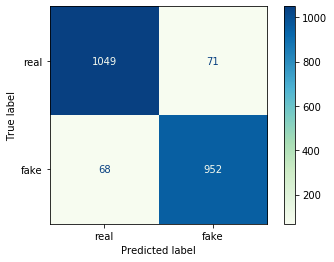

In [109]:
predicted_labels = linear_svc.predict(list(testing_tweets))

# Plot the confusion matrix of the model's predictions
plot_confusion_matrix(linear_svc, list(testing_tweets), list(testing_labels), labels = ['real', 'fake'],
                      cmap = 'GnBu', colorbar = True)

# Printing the performance indicators
print("Performance Indicators:")
measure_performance(list(predicted_labels), list(testing_labels))

- ##### Support Vector Classifier (SVC) with a Radial Basis Function (RBF) Kernel

In [113]:
# Before training the model we need to tune the hyperparameters of this kernel, which are C and Gamma
parameter_grid = {'C': [0.001, 0.01, 0.1, 1],
                  'gamma':[10, 1, 0.1, 0.01],
                 'kernel': ['rbf']}

# refit = True because we want to refit our estimator to the best found parameters
# verbose = 3 because we want to display the candidate parameter indices, the start time of computation and the fold
# k-fold Cross Validation is used and the default number of folds = 5
grid = GridSearchCV(SVC(), parameter_grid, cv = 3, refit = True, verbose = 3, return_train_score = True)

rbf_svc = grid.fit(list(training_tweets), list(training_labels))

print(rbf_svc.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END ..................C=0.001, gamma=10, kernel=rbf; total time=10.2min
[CV 2/3] END ..................C=0.001, gamma=10, kernel=rbf; total time=10.3min
[CV 3/3] END ..................C=0.001, gamma=10, kernel=rbf; total time=10.3min
[CV 1/3] END ...................C=0.001, gamma=1, kernel=rbf; total time=10.4min
[CV 2/3] END ...................C=0.001, gamma=1, kernel=rbf; total time=10.5min
[CV 3/3] END ...................C=0.001, gamma=1, kernel=rbf; total time=10.4min
[CV 1/3] END .................C=0.001, gamma=0.1, kernel=rbf; total time=10.5min
[CV 2/3] END .................C=0.001, gamma=0.1, kernel=rbf; total time=10.4min
[CV 3/3] END .................C=0.001, gamma=0.1, kernel=rbf; total time=10.4min
[CV 1/3] END ................C=0.001, gamma=0.01, kernel=rbf; total time=10.4min
[CV 2/3] END ................C=0.001, gamma=0.01, kernel=rbf; total time=10.3min
[CV 3/3] END ................C=0.001, gamma=0.01

Performance Indicators:
Accuracy: % 93.83
Precision: % 93.9
Recall: % 93.83
F1: % 93.83


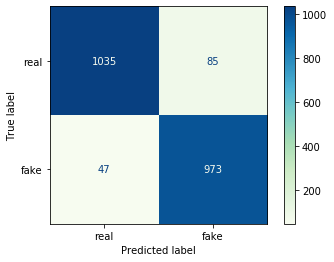

In [114]:
predicted_labels = rbf_svc.predict(list(testing_tweets))

# Plot the confusion matrix of the model's predictions
plot_confusion_matrix(rbf_svc, list(testing_tweets), list(testing_labels), labels = ['real', 'fake'],
                      cmap = 'GnBu', colorbar = True)

# Printing the performance indicators
print("Performance Indicators:")
measure_performance(list(predicted_labels), list(testing_labels))

#### Random Forest

In [118]:
parameter_grid = {
    'n_estimators': [90, 100, 115, 130],
    'max_depth': range(10,20,1),
    'min_samples_leaf': range(2,6,1),
    'min_samples_split': range(2,10,1)
}

grid = GridSearchCV(RandomForestClassifier(), parameter_grid, refit = True, cv = 3, verbose = 3, return_train_score = True)

RF_model = grid.fit(list(training_tweets), list(training_labels))

print(RF_model.best_params_)

Fitting 3 folds for each of 1280 candidates, totalling 3840 fits
[CV 1/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=  11.6s
[CV 2/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=  11.7s
[CV 3/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=  11.6s
[CV 1/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  12.4s
[CV 2/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  12.5s
[CV 3/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  12.8s
[CV 1/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=115; total time=  13.8s
[CV 2/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=115; total time=  13.7s
[CV 3/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=115; total time= 

[CV 1/3] END max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=115; total time=  14.2s
[CV 2/3] END max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=115; total time=  13.6s
[CV 3/3] END max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=115; total time=  13.6s
[CV 1/3] END max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=130; total time=  14.6s
[CV 2/3] END max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=130; total time=  14.8s
[CV 3/3] END max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=130; total time=  14.8s
[CV 1/3] END max_depth=10, min_samples_leaf=2, min_samples_split=9, n_estimators=90; total time=  11.6s
[CV 2/3] END max_depth=10, min_samples_leaf=2, min_samples_split=9, n_estimators=90; total time=  11.3s
[CV 3/3] END max_depth=10, min_samples_leaf=2, min_samples_split=9, n_estimators=90; total time=  11.6s
[CV 1/3] END max_depth=10, min_samples_leaf=2, min_samples

[CV 2/3] END max_depth=10, min_samples_leaf=3, min_samples_split=7, n_estimators=90; total time=  11.5s
[CV 3/3] END max_depth=10, min_samples_leaf=3, min_samples_split=7, n_estimators=90; total time=  11.7s
[CV 1/3] END max_depth=10, min_samples_leaf=3, min_samples_split=7, n_estimators=100; total time=  12.4s
[CV 2/3] END max_depth=10, min_samples_leaf=3, min_samples_split=7, n_estimators=100; total time=  12.3s
[CV 3/3] END max_depth=10, min_samples_leaf=3, min_samples_split=7, n_estimators=100; total time=  12.3s
[CV 1/3] END max_depth=10, min_samples_leaf=3, min_samples_split=7, n_estimators=115; total time=  13.2s
[CV 2/3] END max_depth=10, min_samples_leaf=3, min_samples_split=7, n_estimators=115; total time=  13.6s
[CV 3/3] END max_depth=10, min_samples_leaf=3, min_samples_split=7, n_estimators=115; total time=  13.5s
[CV 1/3] END max_depth=10, min_samples_leaf=3, min_samples_split=7, n_estimators=130; total time=  14.8s
[CV 2/3] END max_depth=10, min_samples_leaf=3, min_sample

[CV 3/3] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=115; total time=  13.5s
[CV 1/3] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=  14.6s
[CV 2/3] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=  14.4s
[CV 3/3] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=  14.6s
[CV 1/3] END max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=90; total time=  10.3s
[CV 2/3] END max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=90; total time=  12.1s
[CV 3/3] END max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=90; total time=  12.2s
[CV 1/3] END max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=  12.8s
[CV 2/3] END max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=  12.3s
[CV 3/3] END max_depth=10, min_samples_leaf=4, min_samples

[CV 1/3] END max_depth=10, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=  12.4s
[CV 2/3] END max_depth=10, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=  12.2s
[CV 3/3] END max_depth=10, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=  12.2s
[CV 1/3] END max_depth=10, min_samples_leaf=5, min_samples_split=4, n_estimators=115; total time=  13.4s
[CV 2/3] END max_depth=10, min_samples_leaf=5, min_samples_split=4, n_estimators=115; total time=  13.2s
[CV 3/3] END max_depth=10, min_samples_leaf=5, min_samples_split=4, n_estimators=115; total time=  13.4s
[CV 1/3] END max_depth=10, min_samples_leaf=5, min_samples_split=4, n_estimators=130; total time=  14.6s
[CV 2/3] END max_depth=10, min_samples_leaf=5, min_samples_split=4, n_estimators=130; total time=  14.6s
[CV 3/3] END max_depth=10, min_samples_leaf=5, min_samples_split=4, n_estimators=130; total time=  14.8s
[CV 1/3] END max_depth=10, min_samples_leaf=5, min_samp

[CV 2/3] END max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=130; total time=  15.3s
[CV 3/3] END max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=130; total time=  15.3s
[CV 1/3] END max_depth=11, min_samples_leaf=2, min_samples_split=3, n_estimators=90; total time=  11.6s
[CV 2/3] END max_depth=11, min_samples_leaf=2, min_samples_split=3, n_estimators=90; total time=  11.9s
[CV 3/3] END max_depth=11, min_samples_leaf=2, min_samples_split=3, n_estimators=90; total time=  11.9s
[CV 1/3] END max_depth=11, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=  12.7s
[CV 2/3] END max_depth=11, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=  12.7s
[CV 3/3] END max_depth=11, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=  12.7s
[CV 1/3] END max_depth=11, min_samples_leaf=2, min_samples_split=3, n_estimators=115; total time=  15.4s
[CV 2/3] END max_depth=11, min_samples_leaf=2, min_samples

[CV 3/3] END max_depth=11, min_samples_leaf=2, min_samples_split=9, n_estimators=100; total time=  12.7s
[CV 1/3] END max_depth=11, min_samples_leaf=2, min_samples_split=9, n_estimators=115; total time=  13.9s
[CV 2/3] END max_depth=11, min_samples_leaf=2, min_samples_split=9, n_estimators=115; total time=  13.8s
[CV 3/3] END max_depth=11, min_samples_leaf=2, min_samples_split=9, n_estimators=115; total time=  14.0s
[CV 1/3] END max_depth=11, min_samples_leaf=2, min_samples_split=9, n_estimators=130; total time=  15.4s
[CV 2/3] END max_depth=11, min_samples_leaf=2, min_samples_split=9, n_estimators=130; total time=  15.3s
[CV 3/3] END max_depth=11, min_samples_leaf=2, min_samples_split=9, n_estimators=130; total time=  15.0s
[CV 1/3] END max_depth=11, min_samples_leaf=3, min_samples_split=2, n_estimators=90; total time=  11.8s
[CV 2/3] END max_depth=11, min_samples_leaf=3, min_samples_split=2, n_estimators=90; total time=  11.8s
[CV 3/3] END max_depth=11, min_samples_leaf=3, min_sample

[CV 1/3] END max_depth=11, min_samples_leaf=3, min_samples_split=8, n_estimators=90; total time=  11.8s
[CV 2/3] END max_depth=11, min_samples_leaf=3, min_samples_split=8, n_estimators=90; total time=  11.7s
[CV 3/3] END max_depth=11, min_samples_leaf=3, min_samples_split=8, n_estimators=90; total time=  11.7s
[CV 1/3] END max_depth=11, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=  12.4s
[CV 2/3] END max_depth=11, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=  12.6s
[CV 3/3] END max_depth=11, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=  12.6s
[CV 1/3] END max_depth=11, min_samples_leaf=3, min_samples_split=8, n_estimators=115; total time=  13.8s
[CV 2/3] END max_depth=11, min_samples_leaf=3, min_samples_split=8, n_estimators=115; total time=  13.7s
[CV 3/3] END max_depth=11, min_samples_leaf=3, min_samples_split=8, n_estimators=115; total time=  15.2s
[CV 1/3] END max_depth=11, min_samples_leaf=3, min_samples

[CV 2/3] END max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=115; total time=  13.9s
[CV 3/3] END max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=115; total time=  13.9s
[CV 1/3] END max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=130; total time=  15.1s
[CV 2/3] END max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=130; total time=  15.0s
[CV 3/3] END max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=130; total time=  14.8s
[CV 1/3] END max_depth=11, min_samples_leaf=4, min_samples_split=7, n_estimators=90; total time=  11.7s
[CV 2/3] END max_depth=11, min_samples_leaf=4, min_samples_split=7, n_estimators=90; total time=  11.7s
[CV 3/3] END max_depth=11, min_samples_leaf=4, min_samples_split=7, n_estimators=90; total time=  11.7s
[CV 1/3] END max_depth=11, min_samples_leaf=4, min_samples_split=7, n_estimators=100; total time=  12.6s
[CV 2/3] END max_depth=11, min_samples_leaf=4, min_samples

[CV 3/3] END max_depth=11, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=  11.7s
[CV 1/3] END max_depth=11, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=  12.6s
[CV 2/3] END max_depth=11, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=  12.5s
[CV 3/3] END max_depth=11, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=  12.5s
[CV 1/3] END max_depth=11, min_samples_leaf=5, min_samples_split=5, n_estimators=115; total time=  13.7s
[CV 2/3] END max_depth=11, min_samples_leaf=5, min_samples_split=5, n_estimators=115; total time=  13.9s
[CV 3/3] END max_depth=11, min_samples_leaf=5, min_samples_split=5, n_estimators=115; total time=  13.9s
[CV 1/3] END max_depth=11, min_samples_leaf=5, min_samples_split=5, n_estimators=130; total time=  14.9s
[CV 2/3] END max_depth=11, min_samples_leaf=5, min_samples_split=5, n_estimators=130; total time=  15.0s
[CV 3/3] END max_depth=11, min_samples_leaf=5, min_sampl

[CV 1/3] END max_depth=12, min_samples_leaf=2, min_samples_split=3, n_estimators=130; total time=  16.2s
[CV 2/3] END max_depth=12, min_samples_leaf=2, min_samples_split=3, n_estimators=130; total time=  16.0s
[CV 3/3] END max_depth=12, min_samples_leaf=2, min_samples_split=3, n_estimators=130; total time=  16.2s
[CV 1/3] END max_depth=12, min_samples_leaf=2, min_samples_split=4, n_estimators=90; total time=  12.5s
[CV 2/3] END max_depth=12, min_samples_leaf=2, min_samples_split=4, n_estimators=90; total time=  12.4s
[CV 3/3] END max_depth=12, min_samples_leaf=2, min_samples_split=4, n_estimators=90; total time=  12.4s
[CV 1/3] END max_depth=12, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=  13.4s
[CV 2/3] END max_depth=12, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=  12.7s
[CV 3/3] END max_depth=12, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=  14.1s
[CV 1/3] END max_depth=12, min_samples_leaf=2, min_samples

[CV 2/3] END max_depth=12, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=  13.3s
[CV 3/3] END max_depth=12, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=  13.3s
[CV 1/3] END max_depth=12, min_samples_leaf=3, min_samples_split=2, n_estimators=115; total time=  14.6s
[CV 2/3] END max_depth=12, min_samples_leaf=3, min_samples_split=2, n_estimators=115; total time=  14.6s
[CV 3/3] END max_depth=12, min_samples_leaf=3, min_samples_split=2, n_estimators=115; total time=  14.7s
[CV 1/3] END max_depth=12, min_samples_leaf=3, min_samples_split=2, n_estimators=130; total time=  15.9s
[CV 2/3] END max_depth=12, min_samples_leaf=3, min_samples_split=2, n_estimators=130; total time=  15.5s
[CV 3/3] END max_depth=12, min_samples_leaf=3, min_samples_split=2, n_estimators=130; total time=  16.1s
[CV 1/3] END max_depth=12, min_samples_leaf=3, min_samples_split=3, n_estimators=90; total time=  12.4s
[CV 2/3] END max_depth=12, min_samples_leaf=3, min_sampl

[CV 3/3] END max_depth=12, min_samples_leaf=3, min_samples_split=8, n_estimators=130; total time=  16.1s
[CV 1/3] END max_depth=12, min_samples_leaf=3, min_samples_split=9, n_estimators=90; total time=  12.4s
[CV 2/3] END max_depth=12, min_samples_leaf=3, min_samples_split=9, n_estimators=90; total time=  12.4s
[CV 3/3] END max_depth=12, min_samples_leaf=3, min_samples_split=9, n_estimators=90; total time=  12.4s
[CV 1/3] END max_depth=12, min_samples_leaf=3, min_samples_split=9, n_estimators=100; total time=  13.1s
[CV 2/3] END max_depth=12, min_samples_leaf=3, min_samples_split=9, n_estimators=100; total time=  13.3s
[CV 3/3] END max_depth=12, min_samples_leaf=3, min_samples_split=9, n_estimators=100; total time=  13.3s
[CV 1/3] END max_depth=12, min_samples_leaf=3, min_samples_split=9, n_estimators=115; total time=  14.6s
[CV 2/3] END max_depth=12, min_samples_leaf=3, min_samples_split=9, n_estimators=115; total time=  14.9s
[CV 3/3] END max_depth=12, min_samples_leaf=3, min_samples

[CV 1/3] END max_depth=12, min_samples_leaf=4, min_samples_split=7, n_estimators=115; total time=  14.6s
[CV 2/3] END max_depth=12, min_samples_leaf=4, min_samples_split=7, n_estimators=115; total time=  14.5s
[CV 3/3] END max_depth=12, min_samples_leaf=4, min_samples_split=7, n_estimators=115; total time=  14.5s
[CV 1/3] END max_depth=12, min_samples_leaf=4, min_samples_split=7, n_estimators=130; total time=  15.9s
[CV 2/3] END max_depth=12, min_samples_leaf=4, min_samples_split=7, n_estimators=130; total time=  15.9s
[CV 3/3] END max_depth=12, min_samples_leaf=4, min_samples_split=7, n_estimators=130; total time=  15.7s
[CV 1/3] END max_depth=12, min_samples_leaf=4, min_samples_split=8, n_estimators=90; total time=  12.3s
[CV 2/3] END max_depth=12, min_samples_leaf=4, min_samples_split=8, n_estimators=90; total time=  12.4s
[CV 3/3] END max_depth=12, min_samples_leaf=4, min_samples_split=8, n_estimators=90; total time=  12.3s
[CV 1/3] END max_depth=12, min_samples_leaf=4, min_samples

[CV 2/3] END max_depth=12, min_samples_leaf=5, min_samples_split=6, n_estimators=90; total time=  12.1s
[CV 3/3] END max_depth=12, min_samples_leaf=5, min_samples_split=6, n_estimators=90; total time=  12.2s
[CV 1/3] END max_depth=12, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=  13.2s
[CV 2/3] END max_depth=12, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=  12.9s
[CV 3/3] END max_depth=12, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=  12.8s
[CV 1/3] END max_depth=12, min_samples_leaf=5, min_samples_split=6, n_estimators=115; total time=  14.5s
[CV 2/3] END max_depth=12, min_samples_leaf=5, min_samples_split=6, n_estimators=115; total time=  14.5s
[CV 3/3] END max_depth=12, min_samples_leaf=5, min_samples_split=6, n_estimators=115; total time=  14.4s
[CV 1/3] END max_depth=12, min_samples_leaf=5, min_samples_split=6, n_estimators=130; total time=  15.8s
[CV 2/3] END max_depth=12, min_samples_leaf=5, min_sample

[CV 3/3] END max_depth=13, min_samples_leaf=2, min_samples_split=4, n_estimators=115; total time=  15.6s
[CV 1/3] END max_depth=13, min_samples_leaf=2, min_samples_split=4, n_estimators=130; total time=  17.0s
[CV 2/3] END max_depth=13, min_samples_leaf=2, min_samples_split=4, n_estimators=130; total time=  17.0s
[CV 3/3] END max_depth=13, min_samples_leaf=2, min_samples_split=4, n_estimators=130; total time=  17.0s
[CV 1/3] END max_depth=13, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=  13.1s
[CV 2/3] END max_depth=13, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=  13.1s
[CV 3/3] END max_depth=13, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=  13.1s
[CV 1/3] END max_depth=13, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  14.1s
[CV 2/3] END max_depth=13, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  14.2s
[CV 3/3] END max_depth=13, min_samples_leaf=2, min_samples

[CV 1/3] END max_depth=13, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=  13.9s
[CV 2/3] END max_depth=13, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=  13.9s
[CV 3/3] END max_depth=13, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=  14.0s
[CV 1/3] END max_depth=13, min_samples_leaf=3, min_samples_split=3, n_estimators=115; total time=  15.4s
[CV 2/3] END max_depth=13, min_samples_leaf=3, min_samples_split=3, n_estimators=115; total time=  15.3s
[CV 3/3] END max_depth=13, min_samples_leaf=3, min_samples_split=3, n_estimators=115; total time=  15.2s
[CV 1/3] END max_depth=13, min_samples_leaf=3, min_samples_split=3, n_estimators=130; total time=  16.9s
[CV 2/3] END max_depth=13, min_samples_leaf=3, min_samples_split=3, n_estimators=130; total time=  16.9s
[CV 3/3] END max_depth=13, min_samples_leaf=3, min_samples_split=3, n_estimators=130; total time=  17.7s
[CV 1/3] END max_depth=13, min_samples_leaf=3, min_samp

[CV 2/3] END max_depth=13, min_samples_leaf=3, min_samples_split=9, n_estimators=130; total time=  16.9s
[CV 3/3] END max_depth=13, min_samples_leaf=3, min_samples_split=9, n_estimators=130; total time=  16.9s
[CV 1/3] END max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=  12.8s
[CV 2/3] END max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=  12.7s
[CV 3/3] END max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=  12.9s
[CV 1/3] END max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  13.8s
[CV 2/3] END max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  13.9s
[CV 3/3] END max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  13.8s
[CV 1/3] END max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=115; total time=  15.2s
[CV 2/3] END max_depth=13, min_samples_leaf=4, min_samples

[CV 3/3] END max_depth=13, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=  13.9s
[CV 1/3] END max_depth=13, min_samples_leaf=4, min_samples_split=8, n_estimators=115; total time=  15.2s
[CV 2/3] END max_depth=13, min_samples_leaf=4, min_samples_split=8, n_estimators=115; total time=  15.1s
[CV 3/3] END max_depth=13, min_samples_leaf=4, min_samples_split=8, n_estimators=115; total time=  15.3s
[CV 1/3] END max_depth=13, min_samples_leaf=4, min_samples_split=8, n_estimators=130; total time=  17.1s
[CV 2/3] END max_depth=13, min_samples_leaf=4, min_samples_split=8, n_estimators=130; total time=  16.7s
[CV 3/3] END max_depth=13, min_samples_leaf=4, min_samples_split=8, n_estimators=130; total time=  16.9s
[CV 1/3] END max_depth=13, min_samples_leaf=4, min_samples_split=9, n_estimators=90; total time=  12.9s
[CV 2/3] END max_depth=13, min_samples_leaf=4, min_samples_split=9, n_estimators=90; total time=  12.9s
[CV 3/3] END max_depth=13, min_samples_leaf=4, min_sample

[CV 1/3] END max_depth=13, min_samples_leaf=5, min_samples_split=7, n_estimators=90; total time=  12.9s
[CV 2/3] END max_depth=13, min_samples_leaf=5, min_samples_split=7, n_estimators=90; total time=  12.9s
[CV 3/3] END max_depth=13, min_samples_leaf=5, min_samples_split=7, n_estimators=90; total time=  12.8s
[CV 1/3] END max_depth=13, min_samples_leaf=5, min_samples_split=7, n_estimators=100; total time=  13.8s
[CV 2/3] END max_depth=13, min_samples_leaf=5, min_samples_split=7, n_estimators=100; total time=  13.8s
[CV 3/3] END max_depth=13, min_samples_leaf=5, min_samples_split=7, n_estimators=100; total time=  13.9s
[CV 1/3] END max_depth=13, min_samples_leaf=5, min_samples_split=7, n_estimators=115; total time=  15.3s
[CV 2/3] END max_depth=13, min_samples_leaf=5, min_samples_split=7, n_estimators=115; total time=  15.3s
[CV 3/3] END max_depth=13, min_samples_leaf=5, min_samples_split=7, n_estimators=115; total time=  15.3s
[CV 1/3] END max_depth=13, min_samples_leaf=5, min_samples

[CV 2/3] END max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=115; total time=  16.1s
[CV 3/3] END max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=115; total time=  16.3s
[CV 1/3] END max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=  17.9s
[CV 2/3] END max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=  18.1s
[CV 3/3] END max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=  17.9s
[CV 1/3] END max_depth=14, min_samples_leaf=2, min_samples_split=6, n_estimators=90; total time=  13.8s
[CV 2/3] END max_depth=14, min_samples_leaf=2, min_samples_split=6, n_estimators=90; total time=  13.6s
[CV 3/3] END max_depth=14, min_samples_leaf=2, min_samples_split=6, n_estimators=90; total time=  13.4s
[CV 1/3] END max_depth=14, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=  14.7s
[CV 2/3] END max_depth=14, min_samples_leaf=2, min_samples

[CV 3/3] END max_depth=14, min_samples_leaf=3, min_samples_split=4, n_estimators=90; total time=  13.6s
[CV 1/3] END max_depth=14, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=  14.6s
[CV 2/3] END max_depth=14, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=  14.4s
[CV 3/3] END max_depth=14, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=  14.6s
[CV 1/3] END max_depth=14, min_samples_leaf=3, min_samples_split=4, n_estimators=115; total time=  16.1s
[CV 2/3] END max_depth=14, min_samples_leaf=3, min_samples_split=4, n_estimators=115; total time=  16.1s
[CV 3/3] END max_depth=14, min_samples_leaf=3, min_samples_split=4, n_estimators=115; total time=  15.9s
[CV 1/3] END max_depth=14, min_samples_leaf=3, min_samples_split=4, n_estimators=130; total time=  17.7s
[CV 2/3] END max_depth=14, min_samples_leaf=3, min_samples_split=4, n_estimators=130; total time=  17.7s
[CV 3/3] END max_depth=14, min_samples_leaf=3, min_sampl

[CV 1/3] END max_depth=14, min_samples_leaf=4, min_samples_split=2, n_estimators=130; total time=  17.5s
[CV 2/3] END max_depth=14, min_samples_leaf=4, min_samples_split=2, n_estimators=130; total time=  17.2s
[CV 3/3] END max_depth=14, min_samples_leaf=4, min_samples_split=2, n_estimators=130; total time=  17.6s
[CV 1/3] END max_depth=14, min_samples_leaf=4, min_samples_split=3, n_estimators=90; total time=  13.4s
[CV 2/3] END max_depth=14, min_samples_leaf=4, min_samples_split=3, n_estimators=90; total time=  13.5s
[CV 3/3] END max_depth=14, min_samples_leaf=4, min_samples_split=3, n_estimators=90; total time=  13.5s
[CV 1/3] END max_depth=14, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=  14.4s
[CV 2/3] END max_depth=14, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=  14.5s
[CV 3/3] END max_depth=14, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=  14.5s
[CV 1/3] END max_depth=14, min_samples_leaf=4, min_samples

[CV 2/3] END max_depth=14, min_samples_leaf=4, min_samples_split=9, n_estimators=100; total time=  14.4s
[CV 3/3] END max_depth=14, min_samples_leaf=4, min_samples_split=9, n_estimators=100; total time=  14.6s
[CV 1/3] END max_depth=14, min_samples_leaf=4, min_samples_split=9, n_estimators=115; total time=  16.2s
[CV 2/3] END max_depth=14, min_samples_leaf=4, min_samples_split=9, n_estimators=115; total time=  16.0s
[CV 3/3] END max_depth=14, min_samples_leaf=4, min_samples_split=9, n_estimators=115; total time=  15.6s
[CV 1/3] END max_depth=14, min_samples_leaf=4, min_samples_split=9, n_estimators=130; total time=  17.5s
[CV 2/3] END max_depth=14, min_samples_leaf=4, min_samples_split=9, n_estimators=130; total time=  17.6s
[CV 3/3] END max_depth=14, min_samples_leaf=4, min_samples_split=9, n_estimators=130; total time=  17.4s
[CV 1/3] END max_depth=14, min_samples_leaf=5, min_samples_split=2, n_estimators=90; total time=  13.4s
[CV 2/3] END max_depth=14, min_samples_leaf=5, min_sampl

[CV 3/3] END max_depth=14, min_samples_leaf=5, min_samples_split=7, n_estimators=130; total time=  17.2s
[CV 1/3] END max_depth=14, min_samples_leaf=5, min_samples_split=8, n_estimators=90; total time=  13.4s
[CV 2/3] END max_depth=14, min_samples_leaf=5, min_samples_split=8, n_estimators=90; total time=  13.4s
[CV 3/3] END max_depth=14, min_samples_leaf=5, min_samples_split=8, n_estimators=90; total time=  13.3s
[CV 1/3] END max_depth=14, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=  14.3s
[CV 2/3] END max_depth=14, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=  14.4s
[CV 3/3] END max_depth=14, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=  14.4s
[CV 1/3] END max_depth=14, min_samples_leaf=5, min_samples_split=8, n_estimators=115; total time=  16.1s
[CV 2/3] END max_depth=14, min_samples_leaf=5, min_samples_split=8, n_estimators=115; total time=  16.0s
[CV 3/3] END max_depth=14, min_samples_leaf=5, min_samples

[CV 1/3] END max_depth=15, min_samples_leaf=2, min_samples_split=6, n_estimators=115; total time=  17.0s
[CV 2/3] END max_depth=15, min_samples_leaf=2, min_samples_split=6, n_estimators=115; total time=  17.3s
[CV 3/3] END max_depth=15, min_samples_leaf=2, min_samples_split=6, n_estimators=115; total time=  17.1s
[CV 1/3] END max_depth=15, min_samples_leaf=2, min_samples_split=6, n_estimators=130; total time=  18.7s
[CV 2/3] END max_depth=15, min_samples_leaf=2, min_samples_split=6, n_estimators=130; total time=  18.7s
[CV 3/3] END max_depth=15, min_samples_leaf=2, min_samples_split=6, n_estimators=130; total time=  18.6s
[CV 1/3] END max_depth=15, min_samples_leaf=2, min_samples_split=7, n_estimators=90; total time=  14.2s
[CV 2/3] END max_depth=15, min_samples_leaf=2, min_samples_split=7, n_estimators=90; total time=  13.9s
[CV 3/3] END max_depth=15, min_samples_leaf=2, min_samples_split=7, n_estimators=90; total time=  14.3s
[CV 1/3] END max_depth=15, min_samples_leaf=2, min_samples

[CV 2/3] END max_depth=15, min_samples_leaf=3, min_samples_split=5, n_estimators=90; total time=  14.2s
[CV 3/3] END max_depth=15, min_samples_leaf=3, min_samples_split=5, n_estimators=90; total time=  14.1s
[CV 1/3] END max_depth=15, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=  15.2s
[CV 2/3] END max_depth=15, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=  15.1s
[CV 3/3] END max_depth=15, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=  16.6s
[CV 1/3] END max_depth=15, min_samples_leaf=3, min_samples_split=5, n_estimators=115; total time=  16.7s
[CV 2/3] END max_depth=15, min_samples_leaf=3, min_samples_split=5, n_estimators=115; total time=  16.9s
[CV 3/3] END max_depth=15, min_samples_leaf=3, min_samples_split=5, n_estimators=115; total time=  17.0s
[CV 1/3] END max_depth=15, min_samples_leaf=3, min_samples_split=5, n_estimators=130; total time=  18.4s
[CV 2/3] END max_depth=15, min_samples_leaf=3, min_sample

[CV 3/3] END max_depth=15, min_samples_leaf=4, min_samples_split=3, n_estimators=115; total time=  16.8s
[CV 1/3] END max_depth=15, min_samples_leaf=4, min_samples_split=3, n_estimators=130; total time=  18.2s
[CV 2/3] END max_depth=15, min_samples_leaf=4, min_samples_split=3, n_estimators=130; total time=  18.6s
[CV 3/3] END max_depth=15, min_samples_leaf=4, min_samples_split=3, n_estimators=130; total time=  18.4s
[CV 1/3] END max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=90; total time=  14.0s
[CV 2/3] END max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=90; total time=  14.0s
[CV 3/3] END max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=90; total time=  13.9s
[CV 1/3] END max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=  15.1s
[CV 2/3] END max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=  15.1s
[CV 3/3] END max_depth=15, min_samples_leaf=4, min_samples

[CV 1/3] END max_depth=15, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  15.6s
[CV 2/3] END max_depth=15, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  15.5s
[CV 3/3] END max_depth=15, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  15.2s
[CV 1/3] END max_depth=15, min_samples_leaf=5, min_samples_split=2, n_estimators=115; total time=  17.0s
[CV 2/3] END max_depth=15, min_samples_leaf=5, min_samples_split=2, n_estimators=115; total time=  17.3s
[CV 3/3] END max_depth=15, min_samples_leaf=5, min_samples_split=2, n_estimators=115; total time=  17.9s
[CV 1/3] END max_depth=15, min_samples_leaf=5, min_samples_split=2, n_estimators=130; total time=  17.2s
[CV 2/3] END max_depth=15, min_samples_leaf=5, min_samples_split=2, n_estimators=130; total time=  17.2s
[CV 3/3] END max_depth=15, min_samples_leaf=5, min_samples_split=2, n_estimators=130; total time=  17.1s
[CV 1/3] END max_depth=15, min_samples_leaf=5, min_samp

[CV 2/3] END max_depth=15, min_samples_leaf=5, min_samples_split=8, n_estimators=130; total time=  18.8s
[CV 3/3] END max_depth=15, min_samples_leaf=5, min_samples_split=8, n_estimators=130; total time=  18.9s
[CV 1/3] END max_depth=15, min_samples_leaf=5, min_samples_split=9, n_estimators=90; total time=  14.3s
[CV 2/3] END max_depth=15, min_samples_leaf=5, min_samples_split=9, n_estimators=90; total time=  14.4s
[CV 3/3] END max_depth=15, min_samples_leaf=5, min_samples_split=9, n_estimators=90; total time=  14.4s
[CV 1/3] END max_depth=15, min_samples_leaf=5, min_samples_split=9, n_estimators=100; total time=  15.5s
[CV 2/3] END max_depth=15, min_samples_leaf=5, min_samples_split=9, n_estimators=100; total time=  15.2s
[CV 3/3] END max_depth=15, min_samples_leaf=5, min_samples_split=9, n_estimators=100; total time=  15.5s
[CV 1/3] END max_depth=15, min_samples_leaf=5, min_samples_split=9, n_estimators=115; total time=  17.0s
[CV 2/3] END max_depth=15, min_samples_leaf=5, min_samples

[CV 3/3] END max_depth=16, min_samples_leaf=2, min_samples_split=7, n_estimators=100; total time=  17.6s
[CV 1/3] END max_depth=16, min_samples_leaf=2, min_samples_split=7, n_estimators=115; total time=  19.1s
[CV 2/3] END max_depth=16, min_samples_leaf=2, min_samples_split=7, n_estimators=115; total time=  19.4s
[CV 3/3] END max_depth=16, min_samples_leaf=2, min_samples_split=7, n_estimators=115; total time=  19.5s
[CV 1/3] END max_depth=16, min_samples_leaf=2, min_samples_split=7, n_estimators=130; total time=  20.7s
[CV 2/3] END max_depth=16, min_samples_leaf=2, min_samples_split=7, n_estimators=130; total time=  21.2s
[CV 3/3] END max_depth=16, min_samples_leaf=2, min_samples_split=7, n_estimators=130; total time=  21.7s
[CV 1/3] END max_depth=16, min_samples_leaf=2, min_samples_split=8, n_estimators=90; total time=  15.8s
[CV 2/3] END max_depth=16, min_samples_leaf=2, min_samples_split=8, n_estimators=90; total time=  16.3s
[CV 3/3] END max_depth=16, min_samples_leaf=2, min_sample

[CV 1/3] END max_depth=16, min_samples_leaf=3, min_samples_split=6, n_estimators=90; total time=  15.1s
[CV 2/3] END max_depth=16, min_samples_leaf=3, min_samples_split=6, n_estimators=90; total time=  15.2s
[CV 3/3] END max_depth=16, min_samples_leaf=3, min_samples_split=6, n_estimators=90; total time=  14.9s
[CV 1/3] END max_depth=16, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=  16.3s
[CV 2/3] END max_depth=16, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=  16.6s
[CV 3/3] END max_depth=16, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=  16.5s
[CV 1/3] END max_depth=16, min_samples_leaf=3, min_samples_split=6, n_estimators=115; total time=  18.3s
[CV 2/3] END max_depth=16, min_samples_leaf=3, min_samples_split=6, n_estimators=115; total time=  18.1s
[CV 3/3] END max_depth=16, min_samples_leaf=3, min_samples_split=6, n_estimators=115; total time=  18.2s
[CV 1/3] END max_depth=16, min_samples_leaf=3, min_samples

[CV 2/3] END max_depth=16, min_samples_leaf=4, min_samples_split=4, n_estimators=115; total time=  17.8s
[CV 3/3] END max_depth=16, min_samples_leaf=4, min_samples_split=4, n_estimators=115; total time=  17.9s
[CV 1/3] END max_depth=16, min_samples_leaf=4, min_samples_split=4, n_estimators=130; total time=  19.6s
[CV 2/3] END max_depth=16, min_samples_leaf=4, min_samples_split=4, n_estimators=130; total time=  19.4s
[CV 3/3] END max_depth=16, min_samples_leaf=4, min_samples_split=4, n_estimators=130; total time=  19.8s
[CV 1/3] END max_depth=16, min_samples_leaf=4, min_samples_split=5, n_estimators=90; total time=  15.1s
[CV 2/3] END max_depth=16, min_samples_leaf=4, min_samples_split=5, n_estimators=90; total time=  15.1s
[CV 3/3] END max_depth=16, min_samples_leaf=4, min_samples_split=5, n_estimators=90; total time=  15.2s
[CV 1/3] END max_depth=16, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  16.3s
[CV 2/3] END max_depth=16, min_samples_leaf=4, min_samples

[CV 3/3] END max_depth=16, min_samples_leaf=5, min_samples_split=3, n_estimators=90; total time=  15.0s
[CV 1/3] END max_depth=16, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=  15.8s
[CV 2/3] END max_depth=16, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=  16.2s
[CV 3/3] END max_depth=16, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=  16.1s
[CV 1/3] END max_depth=16, min_samples_leaf=5, min_samples_split=3, n_estimators=115; total time=  17.4s
[CV 2/3] END max_depth=16, min_samples_leaf=5, min_samples_split=3, n_estimators=115; total time=  17.8s
[CV 3/3] END max_depth=16, min_samples_leaf=5, min_samples_split=3, n_estimators=115; total time=  17.8s
[CV 1/3] END max_depth=16, min_samples_leaf=5, min_samples_split=3, n_estimators=130; total time=  19.6s
[CV 2/3] END max_depth=16, min_samples_leaf=5, min_samples_split=3, n_estimators=130; total time=  20.0s
[CV 3/3] END max_depth=16, min_samples_leaf=5, min_sampl

[CV 1/3] END max_depth=16, min_samples_leaf=5, min_samples_split=9, n_estimators=130; total time=  19.6s
[CV 2/3] END max_depth=16, min_samples_leaf=5, min_samples_split=9, n_estimators=130; total time=  19.7s
[CV 3/3] END max_depth=16, min_samples_leaf=5, min_samples_split=9, n_estimators=130; total time=  19.5s
[CV 1/3] END max_depth=17, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=  15.9s
[CV 2/3] END max_depth=17, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=  15.9s
[CV 3/3] END max_depth=17, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=  16.2s
[CV 1/3] END max_depth=17, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  17.4s
[CV 2/3] END max_depth=17, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  17.5s
[CV 3/3] END max_depth=17, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  17.4s
[CV 1/3] END max_depth=17, min_samples_leaf=2, min_samples

[CV 2/3] END max_depth=17, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=  17.6s
[CV 3/3] END max_depth=17, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=  17.4s
[CV 1/3] END max_depth=17, min_samples_leaf=2, min_samples_split=8, n_estimators=115; total time=  19.3s
[CV 2/3] END max_depth=17, min_samples_leaf=2, min_samples_split=8, n_estimators=115; total time=  19.5s
[CV 3/3] END max_depth=17, min_samples_leaf=2, min_samples_split=8, n_estimators=115; total time=  19.5s
[CV 1/3] END max_depth=17, min_samples_leaf=2, min_samples_split=8, n_estimators=130; total time=  21.2s
[CV 2/3] END max_depth=17, min_samples_leaf=2, min_samples_split=8, n_estimators=130; total time=  21.3s
[CV 3/3] END max_depth=17, min_samples_leaf=2, min_samples_split=8, n_estimators=130; total time=  21.0s
[CV 1/3] END max_depth=17, min_samples_leaf=2, min_samples_split=9, n_estimators=90; total time=  16.2s
[CV 2/3] END max_depth=17, min_samples_leaf=2, min_sampl

[CV 3/3] END max_depth=17, min_samples_leaf=3, min_samples_split=6, n_estimators=130; total time=  21.1s
[CV 1/3] END max_depth=17, min_samples_leaf=3, min_samples_split=7, n_estimators=90; total time=  15.7s
[CV 2/3] END max_depth=17, min_samples_leaf=3, min_samples_split=7, n_estimators=90; total time=  15.9s
[CV 3/3] END max_depth=17, min_samples_leaf=3, min_samples_split=7, n_estimators=90; total time=  16.1s
[CV 1/3] END max_depth=17, min_samples_leaf=3, min_samples_split=7, n_estimators=100; total time=  17.2s
[CV 2/3] END max_depth=17, min_samples_leaf=3, min_samples_split=7, n_estimators=100; total time=  17.2s
[CV 3/3] END max_depth=17, min_samples_leaf=3, min_samples_split=7, n_estimators=100; total time=  17.1s
[CV 1/3] END max_depth=17, min_samples_leaf=3, min_samples_split=7, n_estimators=115; total time=  18.9s
[CV 2/3] END max_depth=17, min_samples_leaf=3, min_samples_split=7, n_estimators=115; total time=  19.0s
[CV 3/3] END max_depth=17, min_samples_leaf=3, min_samples

[CV 1/3] END max_depth=17, min_samples_leaf=4, min_samples_split=5, n_estimators=115; total time=  18.5s
[CV 2/3] END max_depth=17, min_samples_leaf=4, min_samples_split=5, n_estimators=115; total time=  18.7s
[CV 3/3] END max_depth=17, min_samples_leaf=4, min_samples_split=5, n_estimators=115; total time=  18.8s
[CV 1/3] END max_depth=17, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=  20.2s
[CV 2/3] END max_depth=17, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=  20.5s
[CV 3/3] END max_depth=17, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=  20.7s
[CV 1/3] END max_depth=17, min_samples_leaf=4, min_samples_split=6, n_estimators=90; total time=  15.6s
[CV 2/3] END max_depth=17, min_samples_leaf=4, min_samples_split=6, n_estimators=90; total time=  15.6s
[CV 3/3] END max_depth=17, min_samples_leaf=4, min_samples_split=6, n_estimators=90; total time=  15.6s
[CV 1/3] END max_depth=17, min_samples_leaf=4, min_samples

[CV 2/3] END max_depth=17, min_samples_leaf=5, min_samples_split=4, n_estimators=90; total time=  15.5s
[CV 3/3] END max_depth=17, min_samples_leaf=5, min_samples_split=4, n_estimators=90; total time=  15.5s
[CV 1/3] END max_depth=17, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=  16.8s
[CV 2/3] END max_depth=17, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=  16.9s
[CV 3/3] END max_depth=17, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=  16.8s
[CV 1/3] END max_depth=17, min_samples_leaf=5, min_samples_split=4, n_estimators=115; total time=  18.3s
[CV 2/3] END max_depth=17, min_samples_leaf=5, min_samples_split=4, n_estimators=115; total time=  18.5s
[CV 3/3] END max_depth=17, min_samples_leaf=5, min_samples_split=4, n_estimators=115; total time=  18.7s
[CV 1/3] END max_depth=17, min_samples_leaf=5, min_samples_split=4, n_estimators=130; total time=  20.0s
[CV 2/3] END max_depth=17, min_samples_leaf=5, min_sample

[CV 3/3] END max_depth=18, min_samples_leaf=2, min_samples_split=2, n_estimators=115; total time=  19.9s
[CV 1/3] END max_depth=18, min_samples_leaf=2, min_samples_split=2, n_estimators=130; total time=  21.9s
[CV 2/3] END max_depth=18, min_samples_leaf=2, min_samples_split=2, n_estimators=130; total time=  22.2s
[CV 3/3] END max_depth=18, min_samples_leaf=2, min_samples_split=2, n_estimators=130; total time=  21.7s
[CV 1/3] END max_depth=18, min_samples_leaf=2, min_samples_split=3, n_estimators=90; total time=  16.4s
[CV 2/3] END max_depth=18, min_samples_leaf=2, min_samples_split=3, n_estimators=90; total time=  16.5s
[CV 3/3] END max_depth=18, min_samples_leaf=2, min_samples_split=3, n_estimators=90; total time=  16.5s
[CV 1/3] END max_depth=18, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=  17.9s
[CV 2/3] END max_depth=18, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=  17.8s
[CV 3/3] END max_depth=18, min_samples_leaf=2, min_samples

[CV 1/3] END max_depth=18, min_samples_leaf=2, min_samples_split=9, n_estimators=100; total time=  17.7s
[CV 2/3] END max_depth=18, min_samples_leaf=2, min_samples_split=9, n_estimators=100; total time=  17.8s
[CV 3/3] END max_depth=18, min_samples_leaf=2, min_samples_split=9, n_estimators=100; total time=  17.7s
[CV 1/3] END max_depth=18, min_samples_leaf=2, min_samples_split=9, n_estimators=115; total time=  19.9s
[CV 2/3] END max_depth=18, min_samples_leaf=2, min_samples_split=9, n_estimators=115; total time=  19.9s
[CV 3/3] END max_depth=18, min_samples_leaf=2, min_samples_split=9, n_estimators=115; total time=  19.7s
[CV 1/3] END max_depth=18, min_samples_leaf=2, min_samples_split=9, n_estimators=130; total time=  21.8s
[CV 2/3] END max_depth=18, min_samples_leaf=2, min_samples_split=9, n_estimators=130; total time=  22.0s
[CV 3/3] END max_depth=18, min_samples_leaf=2, min_samples_split=9, n_estimators=130; total time=  22.1s
[CV 1/3] END max_depth=18, min_samples_leaf=3, min_samp

[CV 2/3] END max_depth=18, min_samples_leaf=3, min_samples_split=7, n_estimators=130; total time=  20.2s
[CV 3/3] END max_depth=18, min_samples_leaf=3, min_samples_split=7, n_estimators=130; total time=  21.6s
[CV 1/3] END max_depth=18, min_samples_leaf=3, min_samples_split=8, n_estimators=90; total time=  16.1s
[CV 2/3] END max_depth=18, min_samples_leaf=3, min_samples_split=8, n_estimators=90; total time=  15.9s
[CV 3/3] END max_depth=18, min_samples_leaf=3, min_samples_split=8, n_estimators=90; total time=  16.3s
[CV 1/3] END max_depth=18, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=  17.5s
[CV 2/3] END max_depth=18, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=  17.4s
[CV 3/3] END max_depth=18, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=  17.6s
[CV 1/3] END max_depth=18, min_samples_leaf=3, min_samples_split=8, n_estimators=115; total time=  19.6s
[CV 2/3] END max_depth=18, min_samples_leaf=3, min_samples

[CV 3/3] END max_depth=18, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=  17.6s
[CV 1/3] END max_depth=18, min_samples_leaf=4, min_samples_split=6, n_estimators=115; total time=  19.9s
[CV 2/3] END max_depth=18, min_samples_leaf=4, min_samples_split=6, n_estimators=115; total time=  20.0s
[CV 3/3] END max_depth=18, min_samples_leaf=4, min_samples_split=6, n_estimators=115; total time=  20.3s
[CV 1/3] END max_depth=18, min_samples_leaf=4, min_samples_split=6, n_estimators=130; total time=  22.2s
[CV 2/3] END max_depth=18, min_samples_leaf=4, min_samples_split=6, n_estimators=130; total time=  21.7s
[CV 3/3] END max_depth=18, min_samples_leaf=4, min_samples_split=6, n_estimators=130; total time=  21.4s
[CV 1/3] END max_depth=18, min_samples_leaf=4, min_samples_split=7, n_estimators=90; total time=  16.1s
[CV 2/3] END max_depth=18, min_samples_leaf=4, min_samples_split=7, n_estimators=90; total time=  16.3s
[CV 3/3] END max_depth=18, min_samples_leaf=4, min_sample

[CV 1/3] END max_depth=18, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=  15.9s
[CV 2/3] END max_depth=18, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=  15.9s
[CV 3/3] END max_depth=18, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=  16.0s
[CV 1/3] END max_depth=18, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=  17.2s
[CV 2/3] END max_depth=18, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=  17.4s
[CV 3/3] END max_depth=18, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=  17.0s
[CV 1/3] END max_depth=18, min_samples_leaf=5, min_samples_split=5, n_estimators=115; total time=  20.1s
[CV 2/3] END max_depth=18, min_samples_leaf=5, min_samples_split=5, n_estimators=115; total time=  21.9s
[CV 3/3] END max_depth=18, min_samples_leaf=5, min_samples_split=5, n_estimators=115; total time=  19.3s
[CV 1/3] END max_depth=18, min_samples_leaf=5, min_samples

[CV 2/3] END max_depth=19, min_samples_leaf=2, min_samples_split=3, n_estimators=115; total time=  20.4s
[CV 3/3] END max_depth=19, min_samples_leaf=2, min_samples_split=3, n_estimators=115; total time=  20.5s
[CV 1/3] END max_depth=19, min_samples_leaf=2, min_samples_split=3, n_estimators=130; total time=  22.6s
[CV 2/3] END max_depth=19, min_samples_leaf=2, min_samples_split=3, n_estimators=130; total time=  22.7s
[CV 3/3] END max_depth=19, min_samples_leaf=2, min_samples_split=3, n_estimators=130; total time=  22.6s
[CV 1/3] END max_depth=19, min_samples_leaf=2, min_samples_split=4, n_estimators=90; total time=  16.8s
[CV 2/3] END max_depth=19, min_samples_leaf=2, min_samples_split=4, n_estimators=90; total time=  17.0s
[CV 3/3] END max_depth=19, min_samples_leaf=2, min_samples_split=4, n_estimators=90; total time=  17.1s
[CV 1/3] END max_depth=19, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=  18.5s
[CV 2/3] END max_depth=19, min_samples_leaf=2, min_samples

[CV 3/3] END max_depth=19, min_samples_leaf=3, min_samples_split=2, n_estimators=90; total time=  16.9s
[CV 1/3] END max_depth=19, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=  18.1s
[CV 2/3] END max_depth=19, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=  18.2s
[CV 3/3] END max_depth=19, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=  18.2s
[CV 1/3] END max_depth=19, min_samples_leaf=3, min_samples_split=2, n_estimators=115; total time=  20.3s
[CV 2/3] END max_depth=19, min_samples_leaf=3, min_samples_split=2, n_estimators=115; total time=  20.2s
[CV 3/3] END max_depth=19, min_samples_leaf=3, min_samples_split=2, n_estimators=115; total time=  20.2s
[CV 1/3] END max_depth=19, min_samples_leaf=3, min_samples_split=2, n_estimators=130; total time=  22.0s
[CV 2/3] END max_depth=19, min_samples_leaf=3, min_samples_split=2, n_estimators=130; total time=  33.2s
[CV 3/3] END max_depth=19, min_samples_leaf=3, min_sampl

[CV 1/3] END max_depth=19, min_samples_leaf=3, min_samples_split=8, n_estimators=130; total time=  23.4s
[CV 2/3] END max_depth=19, min_samples_leaf=3, min_samples_split=8, n_estimators=130; total time=  22.9s
[CV 3/3] END max_depth=19, min_samples_leaf=3, min_samples_split=8, n_estimators=130; total time=  22.9s
[CV 1/3] END max_depth=19, min_samples_leaf=3, min_samples_split=9, n_estimators=90; total time=  17.3s
[CV 2/3] END max_depth=19, min_samples_leaf=3, min_samples_split=9, n_estimators=90; total time=  17.2s
[CV 3/3] END max_depth=19, min_samples_leaf=3, min_samples_split=9, n_estimators=90; total time=  17.1s
[CV 1/3] END max_depth=19, min_samples_leaf=3, min_samples_split=9, n_estimators=100; total time=  18.3s
[CV 2/3] END max_depth=19, min_samples_leaf=3, min_samples_split=9, n_estimators=100; total time=  18.6s
[CV 3/3] END max_depth=19, min_samples_leaf=3, min_samples_split=9, n_estimators=100; total time=  19.1s
[CV 1/3] END max_depth=19, min_samples_leaf=3, min_samples

[CV 2/3] END max_depth=19, min_samples_leaf=4, min_samples_split=7, n_estimators=100; total time=  18.0s
[CV 3/3] END max_depth=19, min_samples_leaf=4, min_samples_split=7, n_estimators=100; total time=  18.1s
[CV 1/3] END max_depth=19, min_samples_leaf=4, min_samples_split=7, n_estimators=115; total time=  20.0s
[CV 2/3] END max_depth=19, min_samples_leaf=4, min_samples_split=7, n_estimators=115; total time=  20.0s
[CV 3/3] END max_depth=19, min_samples_leaf=4, min_samples_split=7, n_estimators=115; total time=  19.9s
[CV 1/3] END max_depth=19, min_samples_leaf=4, min_samples_split=7, n_estimators=130; total time=  22.1s
[CV 2/3] END max_depth=19, min_samples_leaf=4, min_samples_split=7, n_estimators=130; total time=  20.0s
[CV 3/3] END max_depth=19, min_samples_leaf=4, min_samples_split=7, n_estimators=130; total time=  22.0s
[CV 1/3] END max_depth=19, min_samples_leaf=4, min_samples_split=8, n_estimators=90; total time=  16.5s
[CV 2/3] END max_depth=19, min_samples_leaf=4, min_sampl

[CV 3/3] END max_depth=19, min_samples_leaf=5, min_samples_split=5, n_estimators=130; total time=  22.3s
[CV 1/3] END max_depth=19, min_samples_leaf=5, min_samples_split=6, n_estimators=90; total time=  16.5s
[CV 2/3] END max_depth=19, min_samples_leaf=5, min_samples_split=6, n_estimators=90; total time=  16.5s
[CV 3/3] END max_depth=19, min_samples_leaf=5, min_samples_split=6, n_estimators=90; total time=  16.5s
[CV 1/3] END max_depth=19, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=  17.5s
[CV 2/3] END max_depth=19, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=  17.9s
[CV 3/3] END max_depth=19, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=  17.9s
[CV 1/3] END max_depth=19, min_samples_leaf=5, min_samples_split=6, n_estimators=115; total time=  19.6s
[CV 2/3] END max_depth=19, min_samples_leaf=5, min_samples_split=6, n_estimators=115; total time=  19.7s
[CV 3/3] END max_depth=19, min_samples_leaf=5, min_samples

Performance Indicators:
Accuracy: % 87.66
Precision: % 88.26
Recall: % 87.66
F1: % 87.65


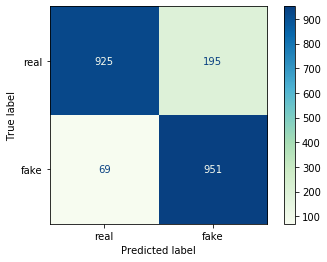

In [119]:
predicted_labels = RF_model.predict(list(testing_tweets))

# Plot the confusion matrix of the model's predictions
plot_confusion_matrix(RF_model, list(testing_tweets), list(testing_labels), labels = ['real', 'fake'],
                      cmap = 'GnBu', colorbar = True)

# Printing the performance indicators
print("Performance Indicators:")
measure_performance(list(predicted_labels), list(testing_labels))